In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import matplotlib.pyplot as plt
import pandas
import common
import config

logging.basicConfig(level=logging.DEBUG)
root_logger = logging.getLogger()
root_logger.setLevel(logging.DEBUG)

matplotlib_logger = logging.getLogger("matplotlib")
matplotlib_logger.setLevel(logging.WARNING)

In [3]:
manager = common.DatasetManager(config.TLHOP_EPSS_REPORT_PATH)
manager.load_datasets()

day = "2024-06-26"
votes_df = manager.votes_df.copy()
manager.join_columns(votes_df, day)

features = votes_df.apply(common.extract_row_features, axis=1)
features_df = pandas.DataFrame(features.tolist())

INFO:root:Selected 2 of 2 commits, start=2024-05-02 end=2024-06-26
INFO:root:Loaded classifications for 43754 orgs
INFO:root:Loaded classifications for 247311 CVEs
INFO:root:KEV database has 1222 CVEs
/home/cunha/git/network-security/xgboost_handling/common.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pandas.read_sql(query, connection)
INFO:root:Read table users from PostgreSQL, 8 rows
INFO:root:Read table votes from PostgreSQL, 1369 rows
INFO:root:Loaded 1369 votes from 8 users
INFO:root:Merged Shodan columns
INFO:root:Built in_kev column
INFO:root:Merged organization columns
INFO:root:Merged CVE columns


<Figure size 1000x600 with 0 Axes>

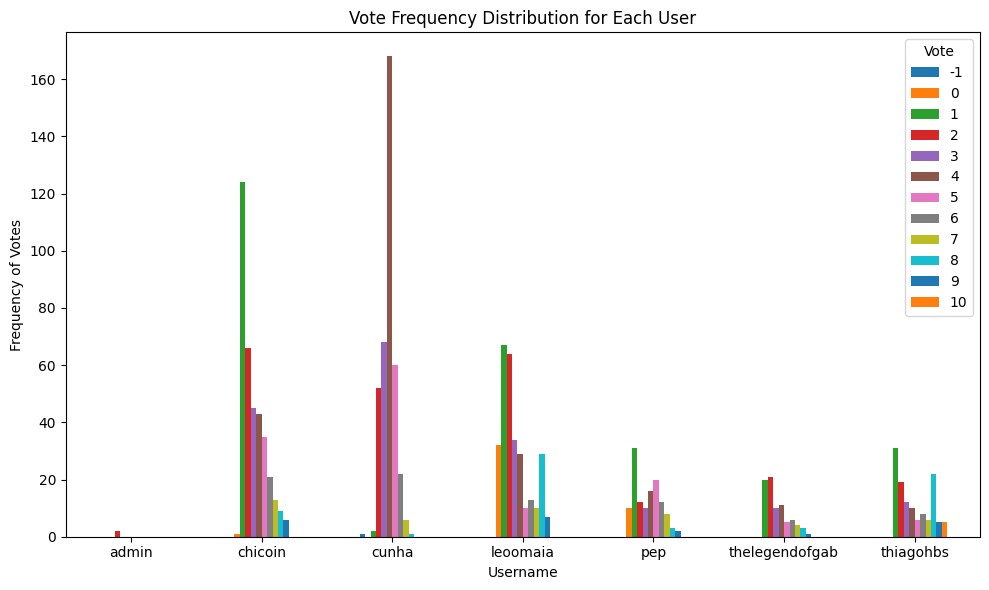

In [4]:
df = manager.votes_df.copy()

plt.figure(figsize=(10, 6))

vote_counts = df.groupby(["username", "vote"]).size().unstack(fill_value=0)

vote_counts.plot(kind="bar", stacked=False, figsize=(10, 6))

plt.title("Vote Frequency Distribution for Each User")
plt.xlabel("Username")
plt.ylabel("Frequency of Votes")
plt.xticks(rotation=0)
plt.legend(title="Vote", loc="upper right")

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

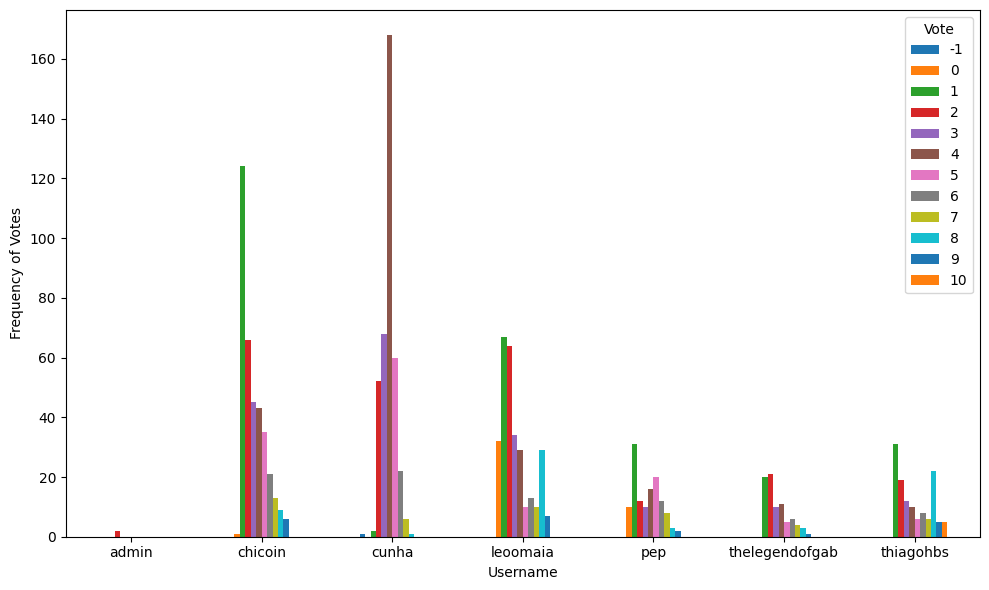

In [7]:
filtered_df = df[df["datestr"] > "2024-10-21"]

plt.figure(figsize=(10, 6))

vote_counts_filtered = (
    df.groupby(["username", "vote"]).size().unstack(fill_value=0)
)

vote_counts_filtered.plot(kind="bar", stacked=False, figsize=(10, 6))

plt.xlabel("Username")
plt.ylabel("Frequency of Votes")
plt.xticks(rotation=0)
plt.legend(title="Vote", loc="upper right")

plt.tight_layout()
plt.show()

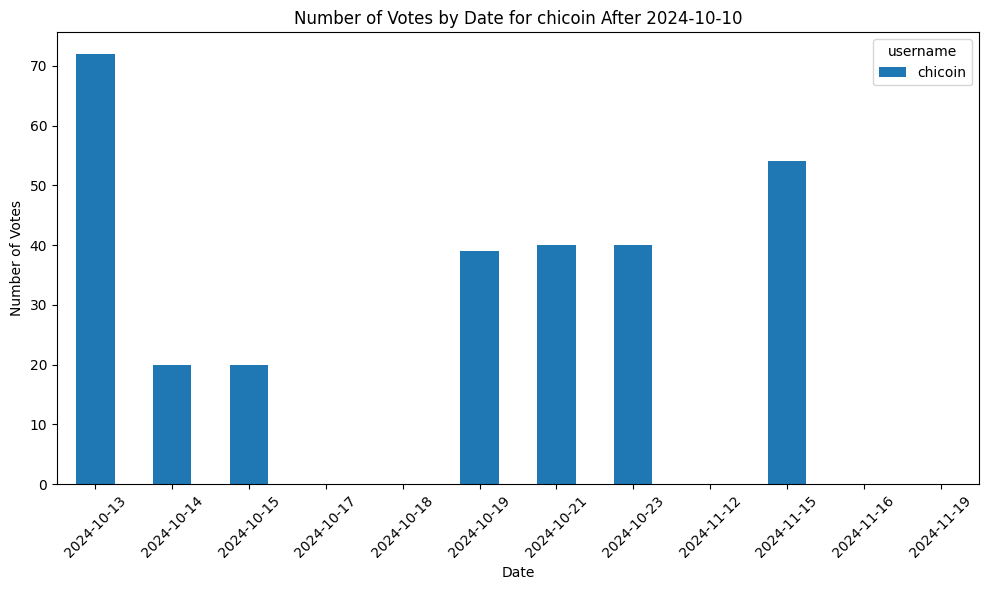

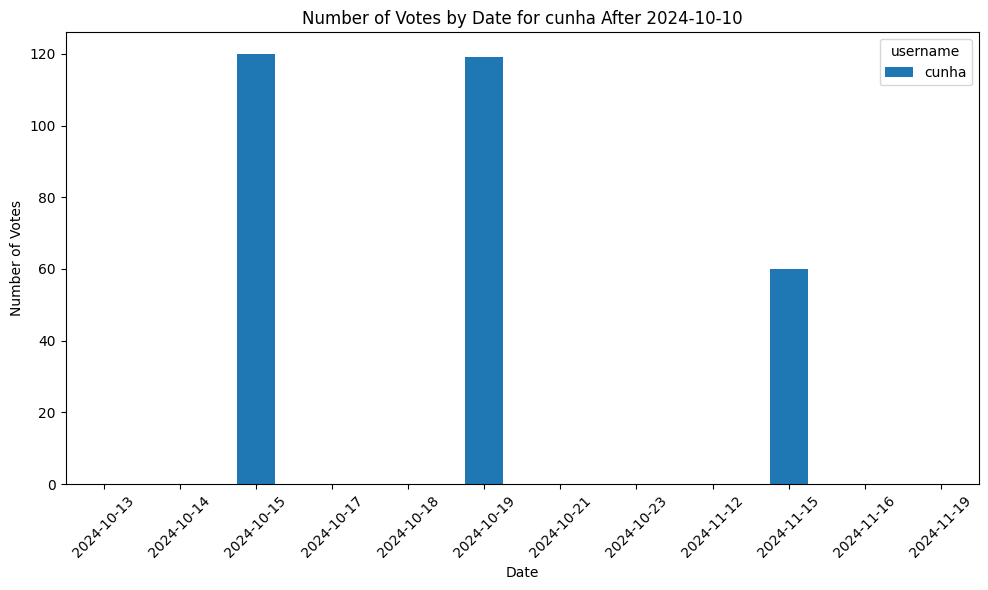

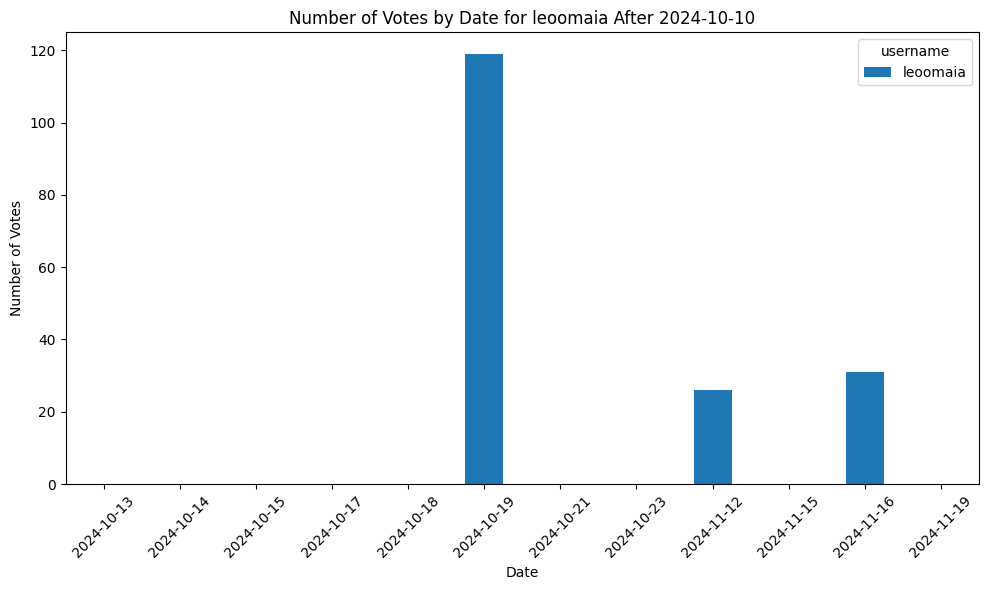

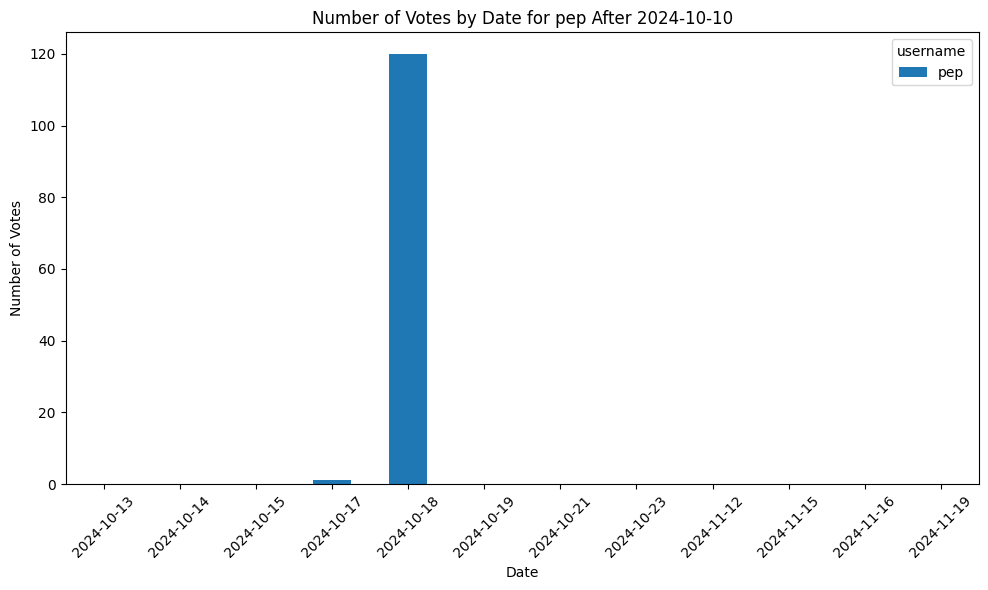

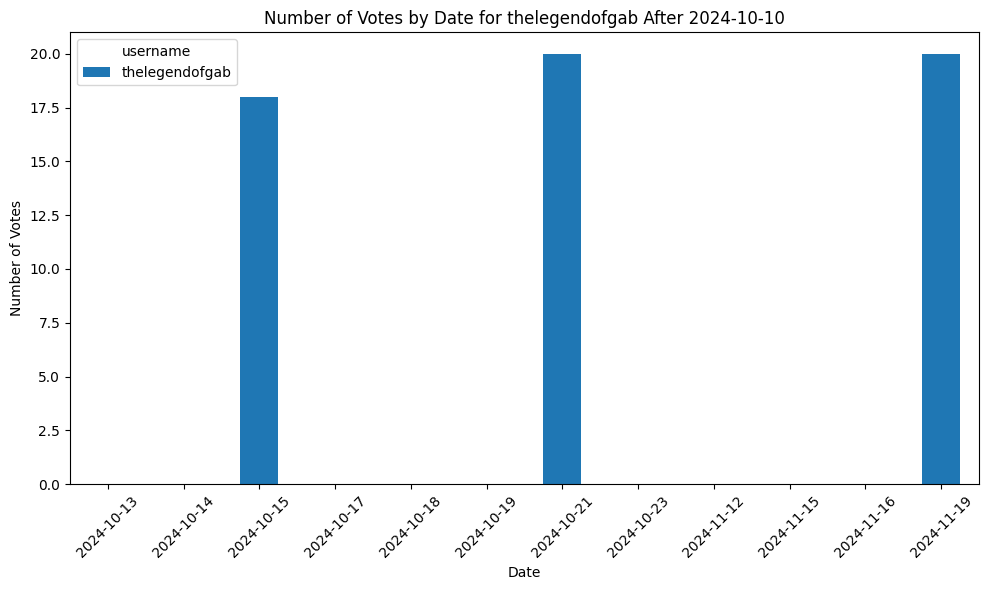

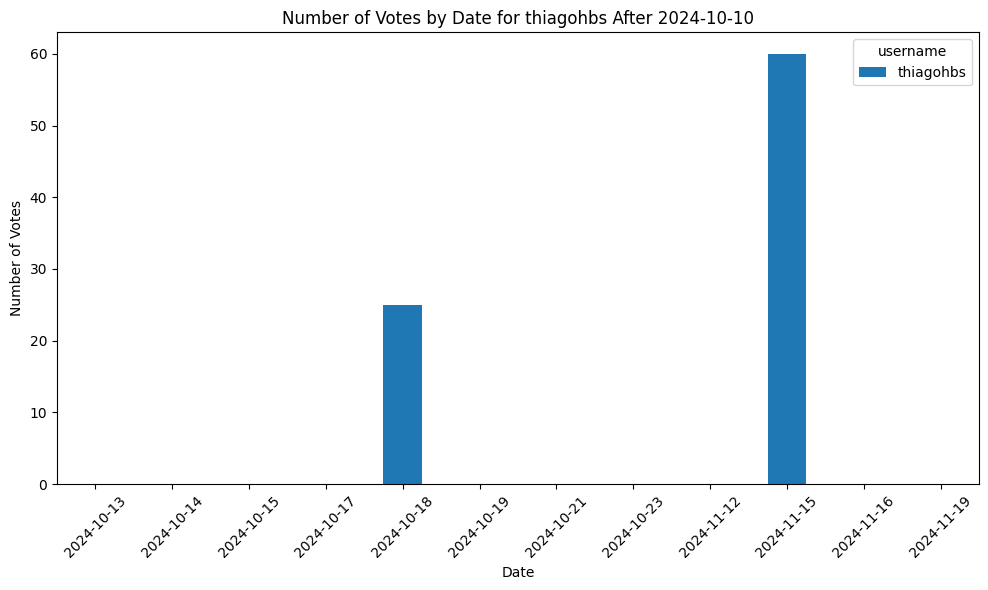

In [9]:
filtered_df = df[df["datestr"] > "2024-10-10"]

filtered_vote_counts = (
    filtered_df.groupby(["datestr", "username"]).size().unstack(fill_value=0)
)

for user in filtered_vote_counts.columns:
    filtered_vote_counts[[user]].plot(kind="bar", figsize=(10, 6))

    plt.title(f"Number of Votes by Date for {user} After 2024-10-10")
    plt.xlabel("Date")
    plt.ylabel("Number of Votes")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

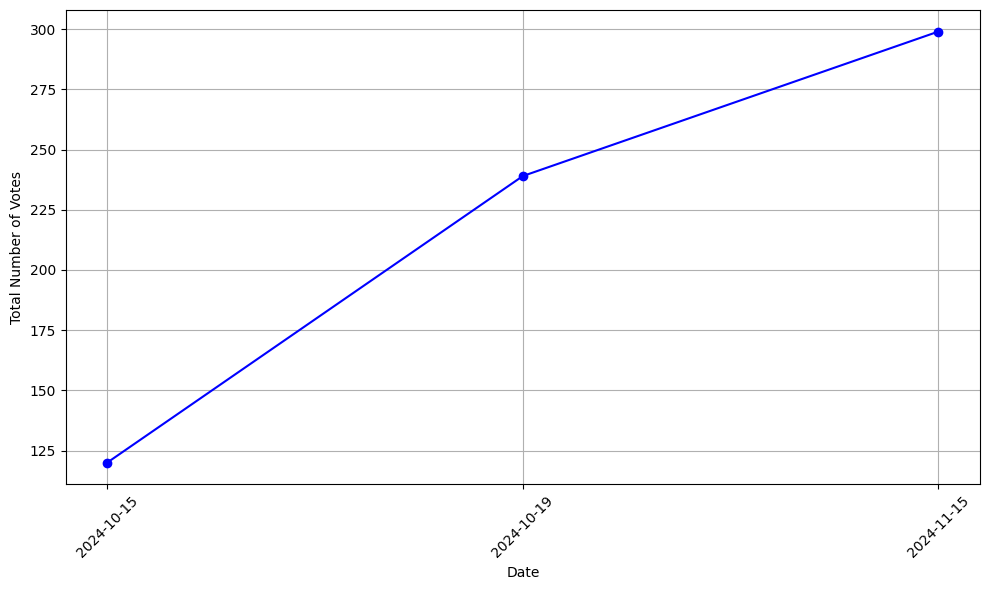

In [11]:
filtered_df_chicoin = df[
    (df["datestr"] > "2024-10-10") & (df["username"] == "cunha")
]

vote_counts_chicoin = filtered_df_chicoin.groupby("datestr").size().cumsum()

plt.figure(figsize=(10, 6))
plt.plot(vote_counts_chicoin, marker="o", linestyle="-", color="b")

plt.xlabel("Date")
plt.ylabel("Total Number of Votes")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
# for col in ['org_x', 'isp', 'city', 'region_code', 'os', 'user_name', 'uuid', 'org_y', 'org_name']:
#    features_df[col] = features_df[col].astype('category')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


splits = [0.5, 0.7, 0.8, 0.9, 0.95]

average_rmse_dict = {split: [] for split in splits}

unique_users = features_df["user_name"].unique()

for split in splits:
    for user in unique_users:
        user_accuracies = []

        user_data = features_df[features_df["user_name"] == user]

        if len(user_data) < 2:
            print(f"Skipping user: {user} due to insufficient data.")
            continue

        for iteration in range(10):
            seed = iteration + 33

            train_size = int(0.8 * len(user_data))
            X = user_data.drop(
                columns=["ip_str", "user_id", "user_name", "vote"]
            )  # Features
            y = user_data["vote"]  # Target

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=(1 - split), random_state=seed, shuffle=True
            )

            model = XGBRegressor(
                n_estimators=1000,
                learning_rate=0.1,
                max_depth=15,
                verbosity=0,
                enable_categorical=True,
                random_state=seed,
            )
            X_train[['port', 'device', 'devicetype']] = X_train[['port', 'device', 'devicetype']].astype('category')
            model.fit(X_train, y_train)

            X_test[['port', 'device', 'devicetype']] = X_test[['port', 'device', 'devicetype']].astype('category')
            y_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            user_accuracies.append(rmse)

        average_rmse_dict[split].append(np.mean(user_accuracies))


In [ ]:
plt.figure(figsize=(10, 6))

user_names = []

x_positions = np.linspace(1, len(splits), len(splits))

user_rmse_dict = {
    user: [] for user in features_df["user_name"].unique() if user != "thelegendofgab"
}  # Exclude "thelegendofgab"
user_vote_counts = features_df["user_name"].value_counts().to_dict()

user_error_dict = {user: [] for user in user_rmse_dict.keys()}
user_std_dev_dict = {user: [] for user in user_rmse_dict.keys()}

for split_index, (split, avg_rmse_list) in enumerate(average_rmse_dict.items()):
    for i, rmse in enumerate(avg_rmse_list):
        user_name = features_df["user_name"].unique()[i]
        if user_name == "thelegendofgab":
            continue  # Skip this user

        plt.plot(
            x_positions[split_index],
            rmse,
            marker="o",
            linestyle="",
            label="" if split_index == 0 else "",
        )

        user_rmse_dict[user_name].append(rmse)

        error = rmse
        user_error_dict[user_name].append(error)

for user, rmse_values in user_rmse_dict.items():
    n_votes = user_vote_counts.get(user, 0)  # Get the vote count

    avg_rmse = np.mean(rmse_values)
    std_dev = np.std(rmse_values)

    plt.plot(x_positions, rmse_values, linestyle="-", marker="o", label=f"{user}")

    plt.fill_between(
        x_positions,
        np.array(rmse_values) - std_dev,
        np.array(rmse_values) + std_dev,
        alpha=0.2,
    )  # Shaded area for standard deviation

for user, rmse_values in user_rmse_dict.items():
    if rmse_values:
        plt.annotate(
            user,
            (x_positions[0], rmse_values[0]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
            fontsize=16,
        )

plt.xticks(x_positions, ["50/50", "70/30", "80/20", "90/10", "95/5"], fontsize=20)
plt.xlabel("% de Base Utilizada para Treino", fontsize=20)
plt.ylabel("RMSE Médio", fontsize=20)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()

plt.tick_params(axis="both", which="major", labelsize=20)

plt.show()